In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../data/Netflix Dataset.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


### CHECK IF WE HAVE GPU

In [5]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### DATA CORRECTION AND MODIFICATION

In [6]:
df[["year", "month", "dates"]] = df["Date"].str.split("-", expand = True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,dates
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,2002,05,23
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,2002,05,24
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,2002,05,28
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,2002,05,29
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,2002,05,30


In [7]:
df.shape

(5540, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5540 entries, 0 to 5539
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5540 non-null   object 
 1   Open       5540 non-null   float64
 2   High       5540 non-null   float64
 3   Low        5540 non-null   float64
 4   Close      5540 non-null   float64
 5   Adj Close  5540 non-null   float64
 6   Volume     5540 non-null   int64  
 7   year       5540 non-null   object 
 8   month      5540 non-null   object 
 9   dates      5540 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 432.9+ KB


# DATA CATELOG

### DATA COLS
- Close : The closing price of Netflix stock on the given day.
- High : The highest price of Netflix stock during the trading day.

## EDA

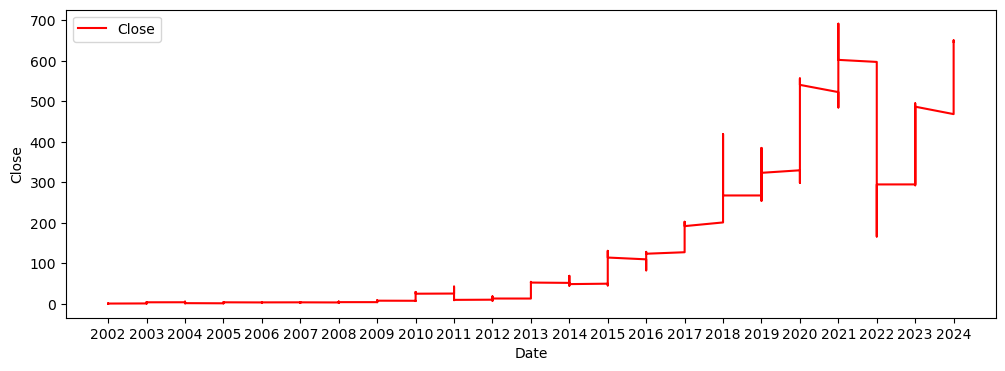

In [9]:
colors = ['red'] 
plt.figure(figsize=(12, 4))  # Adjust the size as needed
plt.plot(df['year'], df['Close'], color=colors[0], label="Close")
plt.xlabel('Date', fontsize=10)  # Corrected x-axis label function
plt.ylabel("Close", fontsize=10)  # Assuming col is defined elsewhere
plt.legend() # Add a legend for each subplot
plt.show() # Show the plot

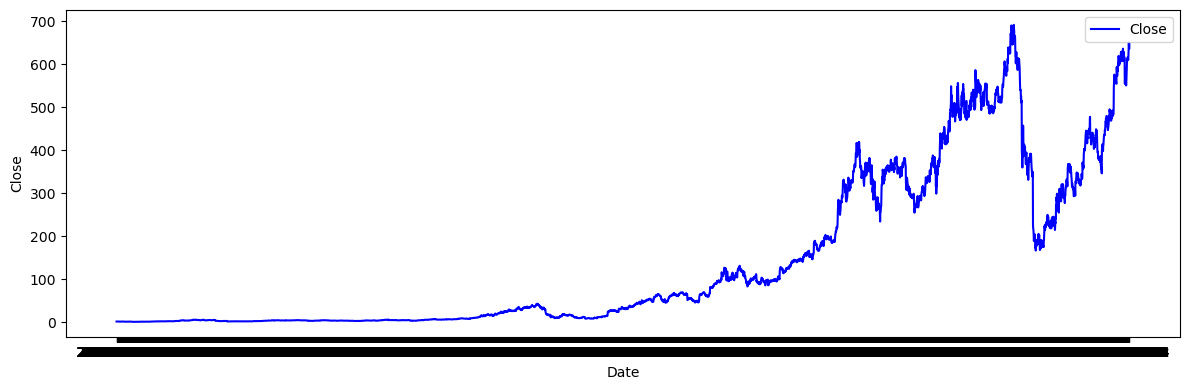

In [27]:
# Assuming df and col are defined elsewhere
colors = ['blue'] 
plt.figure(figsize=(12, 4))  # Adjust the size as needed
plt.plot(df['Date'], df['Close'], color=colors[0], label="Close")
plt.xlabel('Date')  
plt.ylabel("Close")
plt.legend() 
plt.tight_layout() 
plt.show()

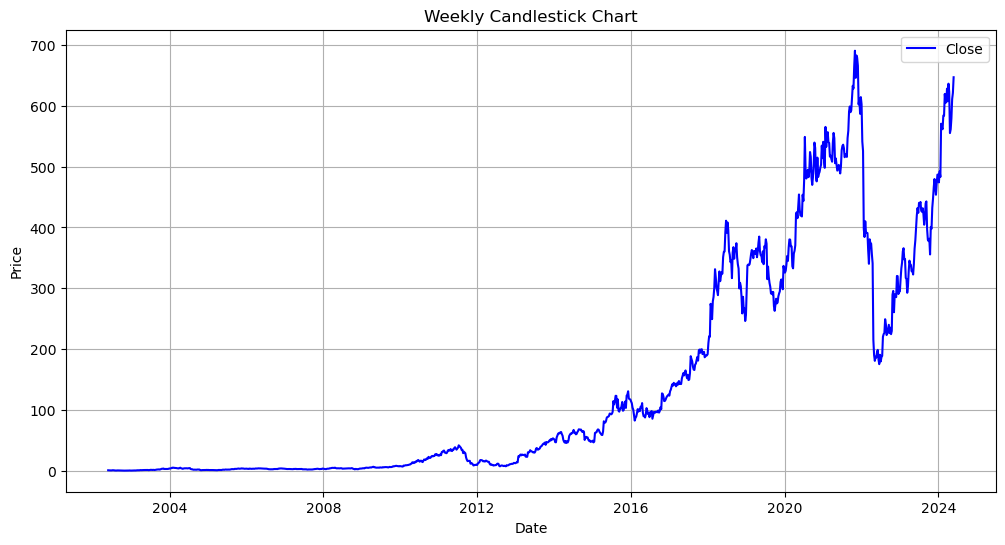

In [28]:
import matplotlib.pyplot as plt

df1= df.copy()
df1.index = pd.to_datetime(df.Date)

# Assuming your DataFrame has columns: 'Date', 'Open', 'High', 'Low', 'Close'
# And 'Date' is in datetime format and is your index

# Resample the data to weekly frequency
weekly_df = df1.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_df.index, weekly_df['Close'], color='blue', label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Weekly Candlestick Chart')
plt.legend()
plt.grid(True)
plt.show()



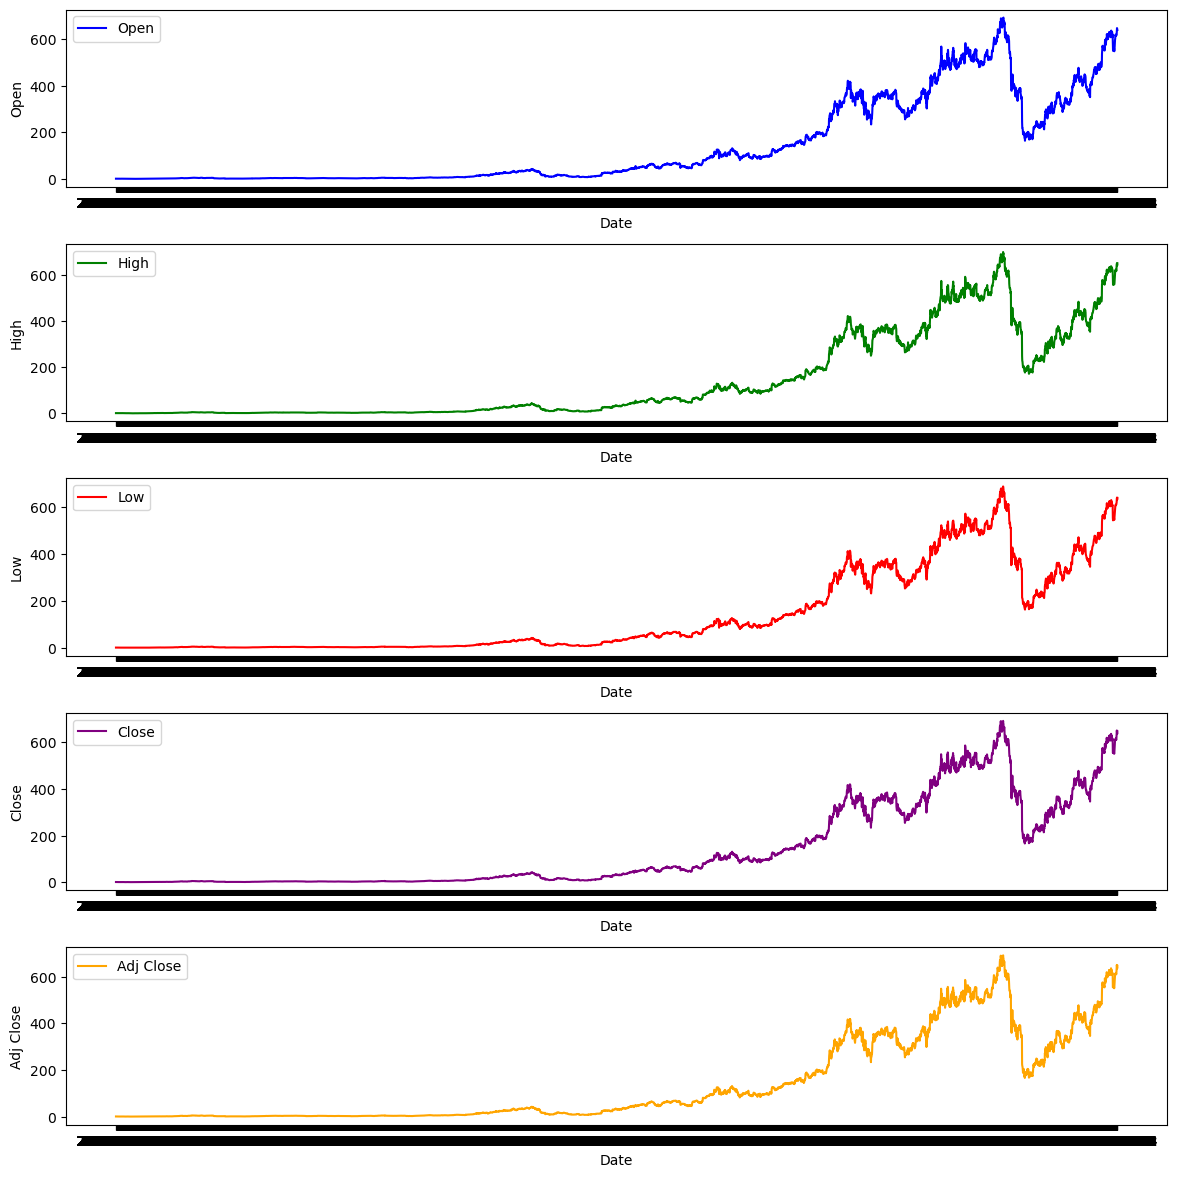

In [29]:

# Create subplots with adjusted figure size
fig, axes = plt.subplots(5, 1, figsize=(12, 12))

# Customize spacing for better readability
fig.tight_layout(pad=2.0)

# Define a color palette for visual distinction (you can customize this)
colors = ['blue', 'green', 'red', 'purple', 'orange'] 

# Iterate through columns and create plots
for index, col in enumerate(df.columns[1:6]):
    axes[index].plot(df['Date'], df[col], color=colors[index], label=col)
    axes[index].set_xlabel('Date', fontsize=10)  # Adjust font size as needed
    axes[index].set_ylabel(col, fontsize=10)
    axes[index].legend() # Add a legend for each subplot
    fig.show() # Show each plot individually within the loop 

## Moving Averages

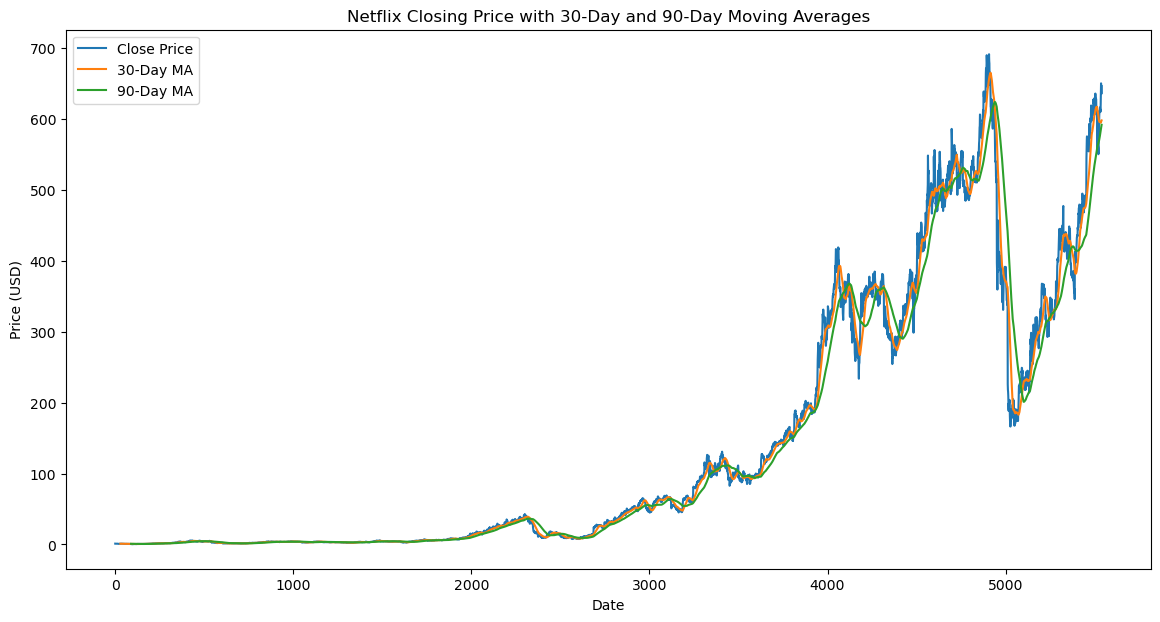

In [30]:
# Calculate moving averages
df['MA30'] = df['Close'].rolling(window=30).mean()
df['MA90'] = df['Close'].rolling(window=90).mean()

# Plot closing price with moving averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA30'], label='30-Day MA')
plt.plot(df['MA90'], label='90-Day MA')
plt.title('Netflix Closing Price with 30-Day and 90-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(False)
plt.show()

## VOLUME ANALYSIS

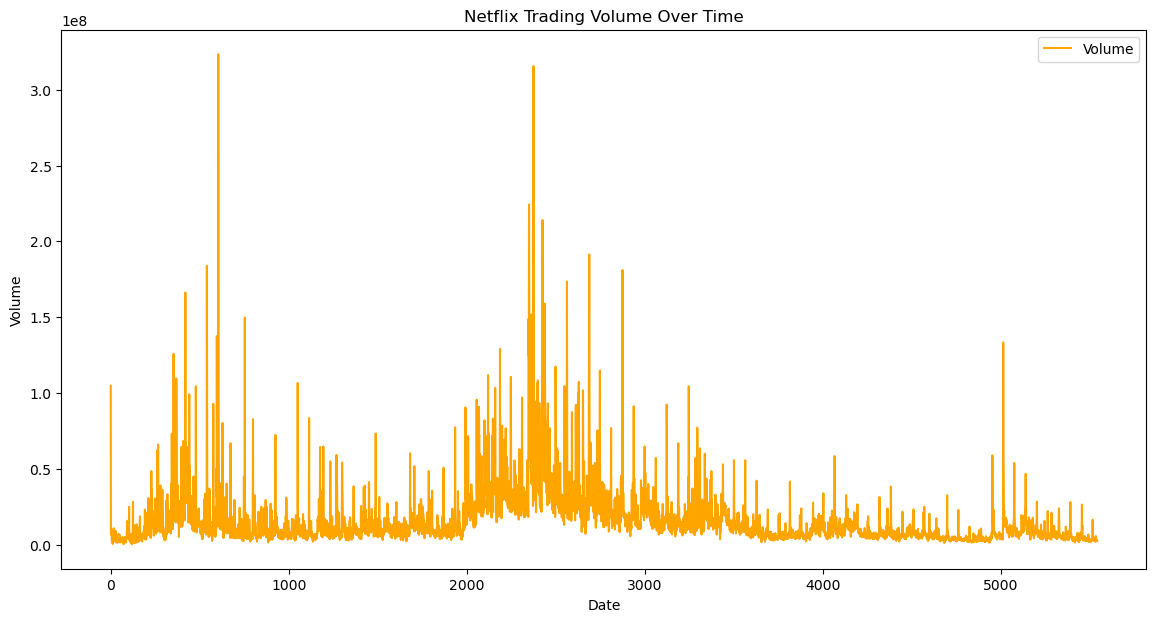

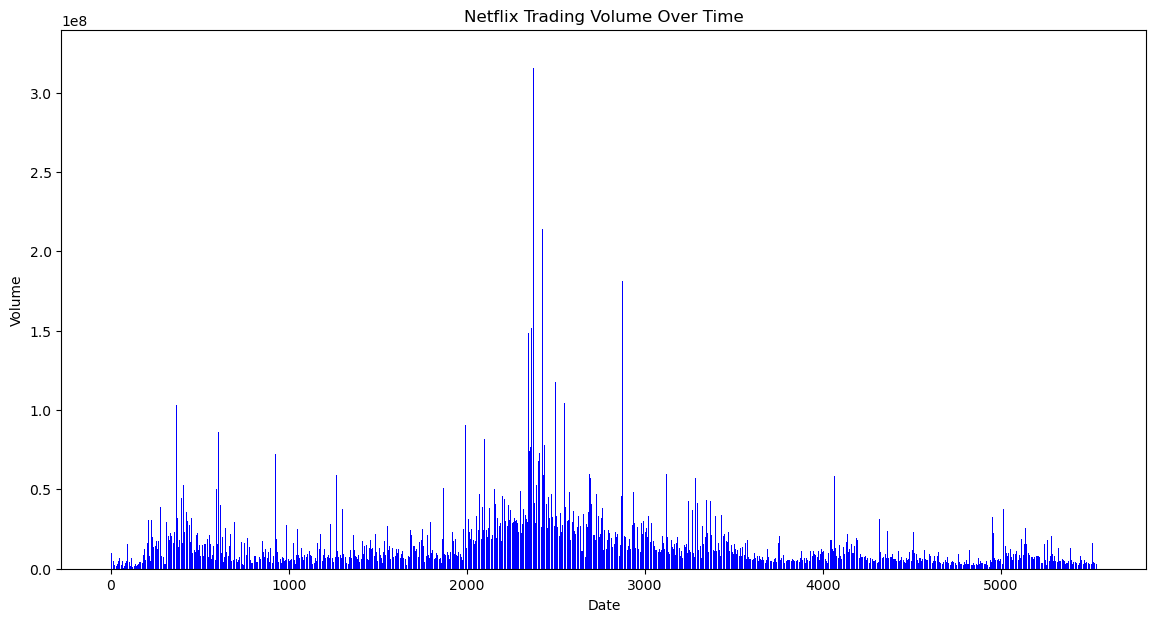

In [32]:
# Plot trading volume over time
plt.figure(figsize=(14, 7))
plt.plot(df['Volume'], label='Volume', color='orange')
plt.title('Netflix Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(False)
plt.show()
# Plot a bar chart of trading volume over time
plt.figure(figsize=(14, 7))
plt.bar(df.index, df['Volume'], color='blue')
plt.title('Netflix Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


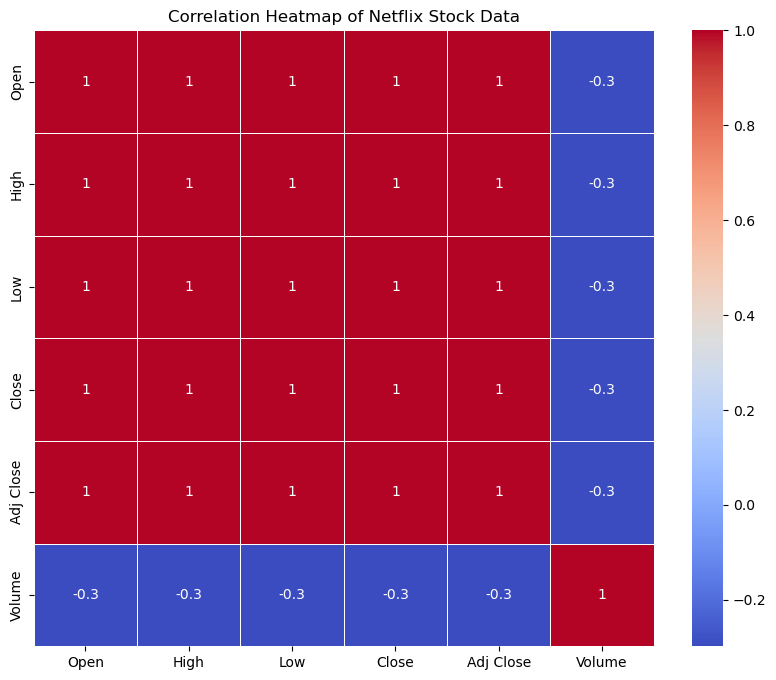

In [33]:
import seaborn as sns

# Calculate correlation matrix
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Netflix Stock Data')
plt.show()

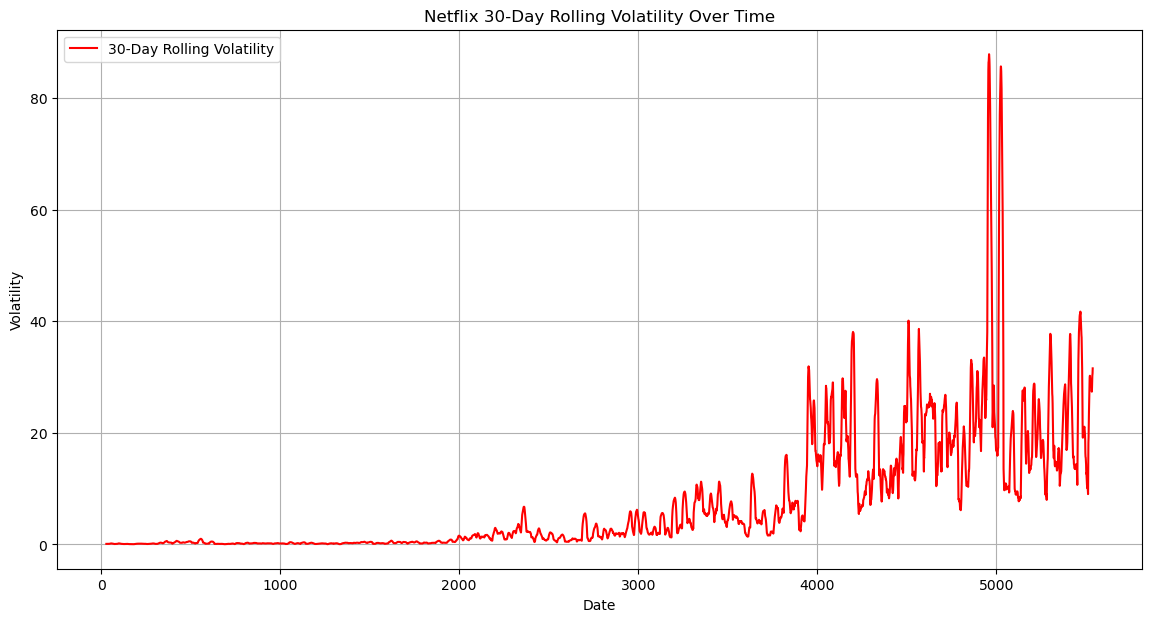

In [35]:
# Calculate rolling standard deviation (volatility)
df['Volatility'] = df['Close'].rolling(window=30).std()

# Plot volatility over time
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'], label='30-Day Rolling Volatility', color='red')
plt.title('Netflix 30-Day Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

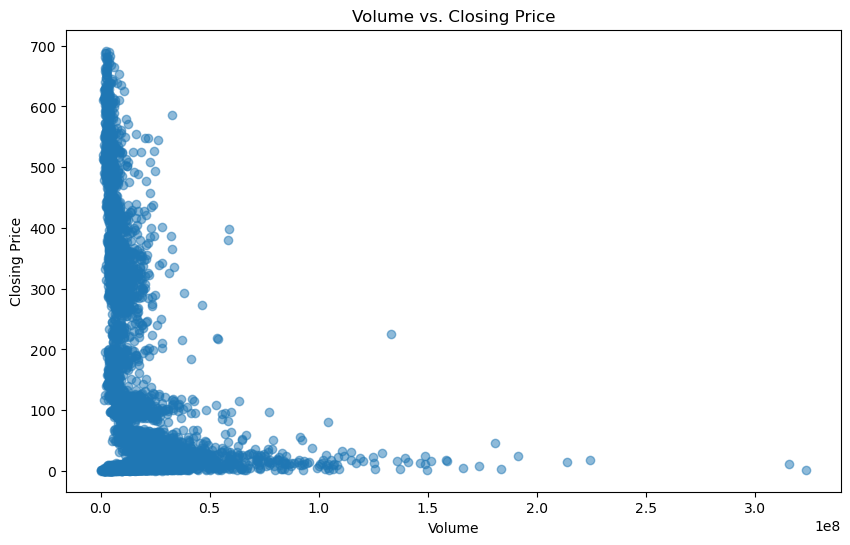

In [36]:
# Scatter Plot: Volume vs. Closing Price
plt.figure(figsize=(10, 6))
plt.scatter(df['Volume'], df['Close'], alpha=0.5)
plt.title('Volume vs. Closing Price')
plt.xlabel('Volume')
plt.ylabel('Closing Price')
plt.show()

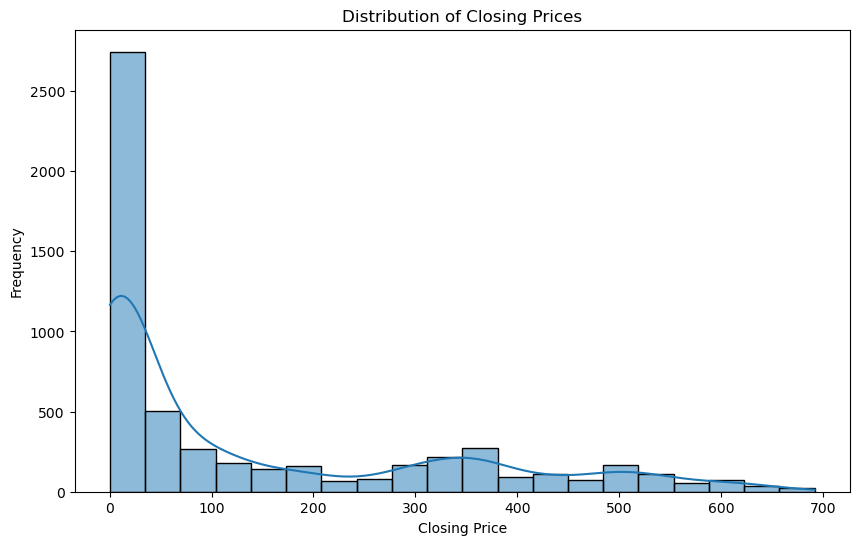

In [50]:
# Histogram: Distribution of Closing Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True, bins=20)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

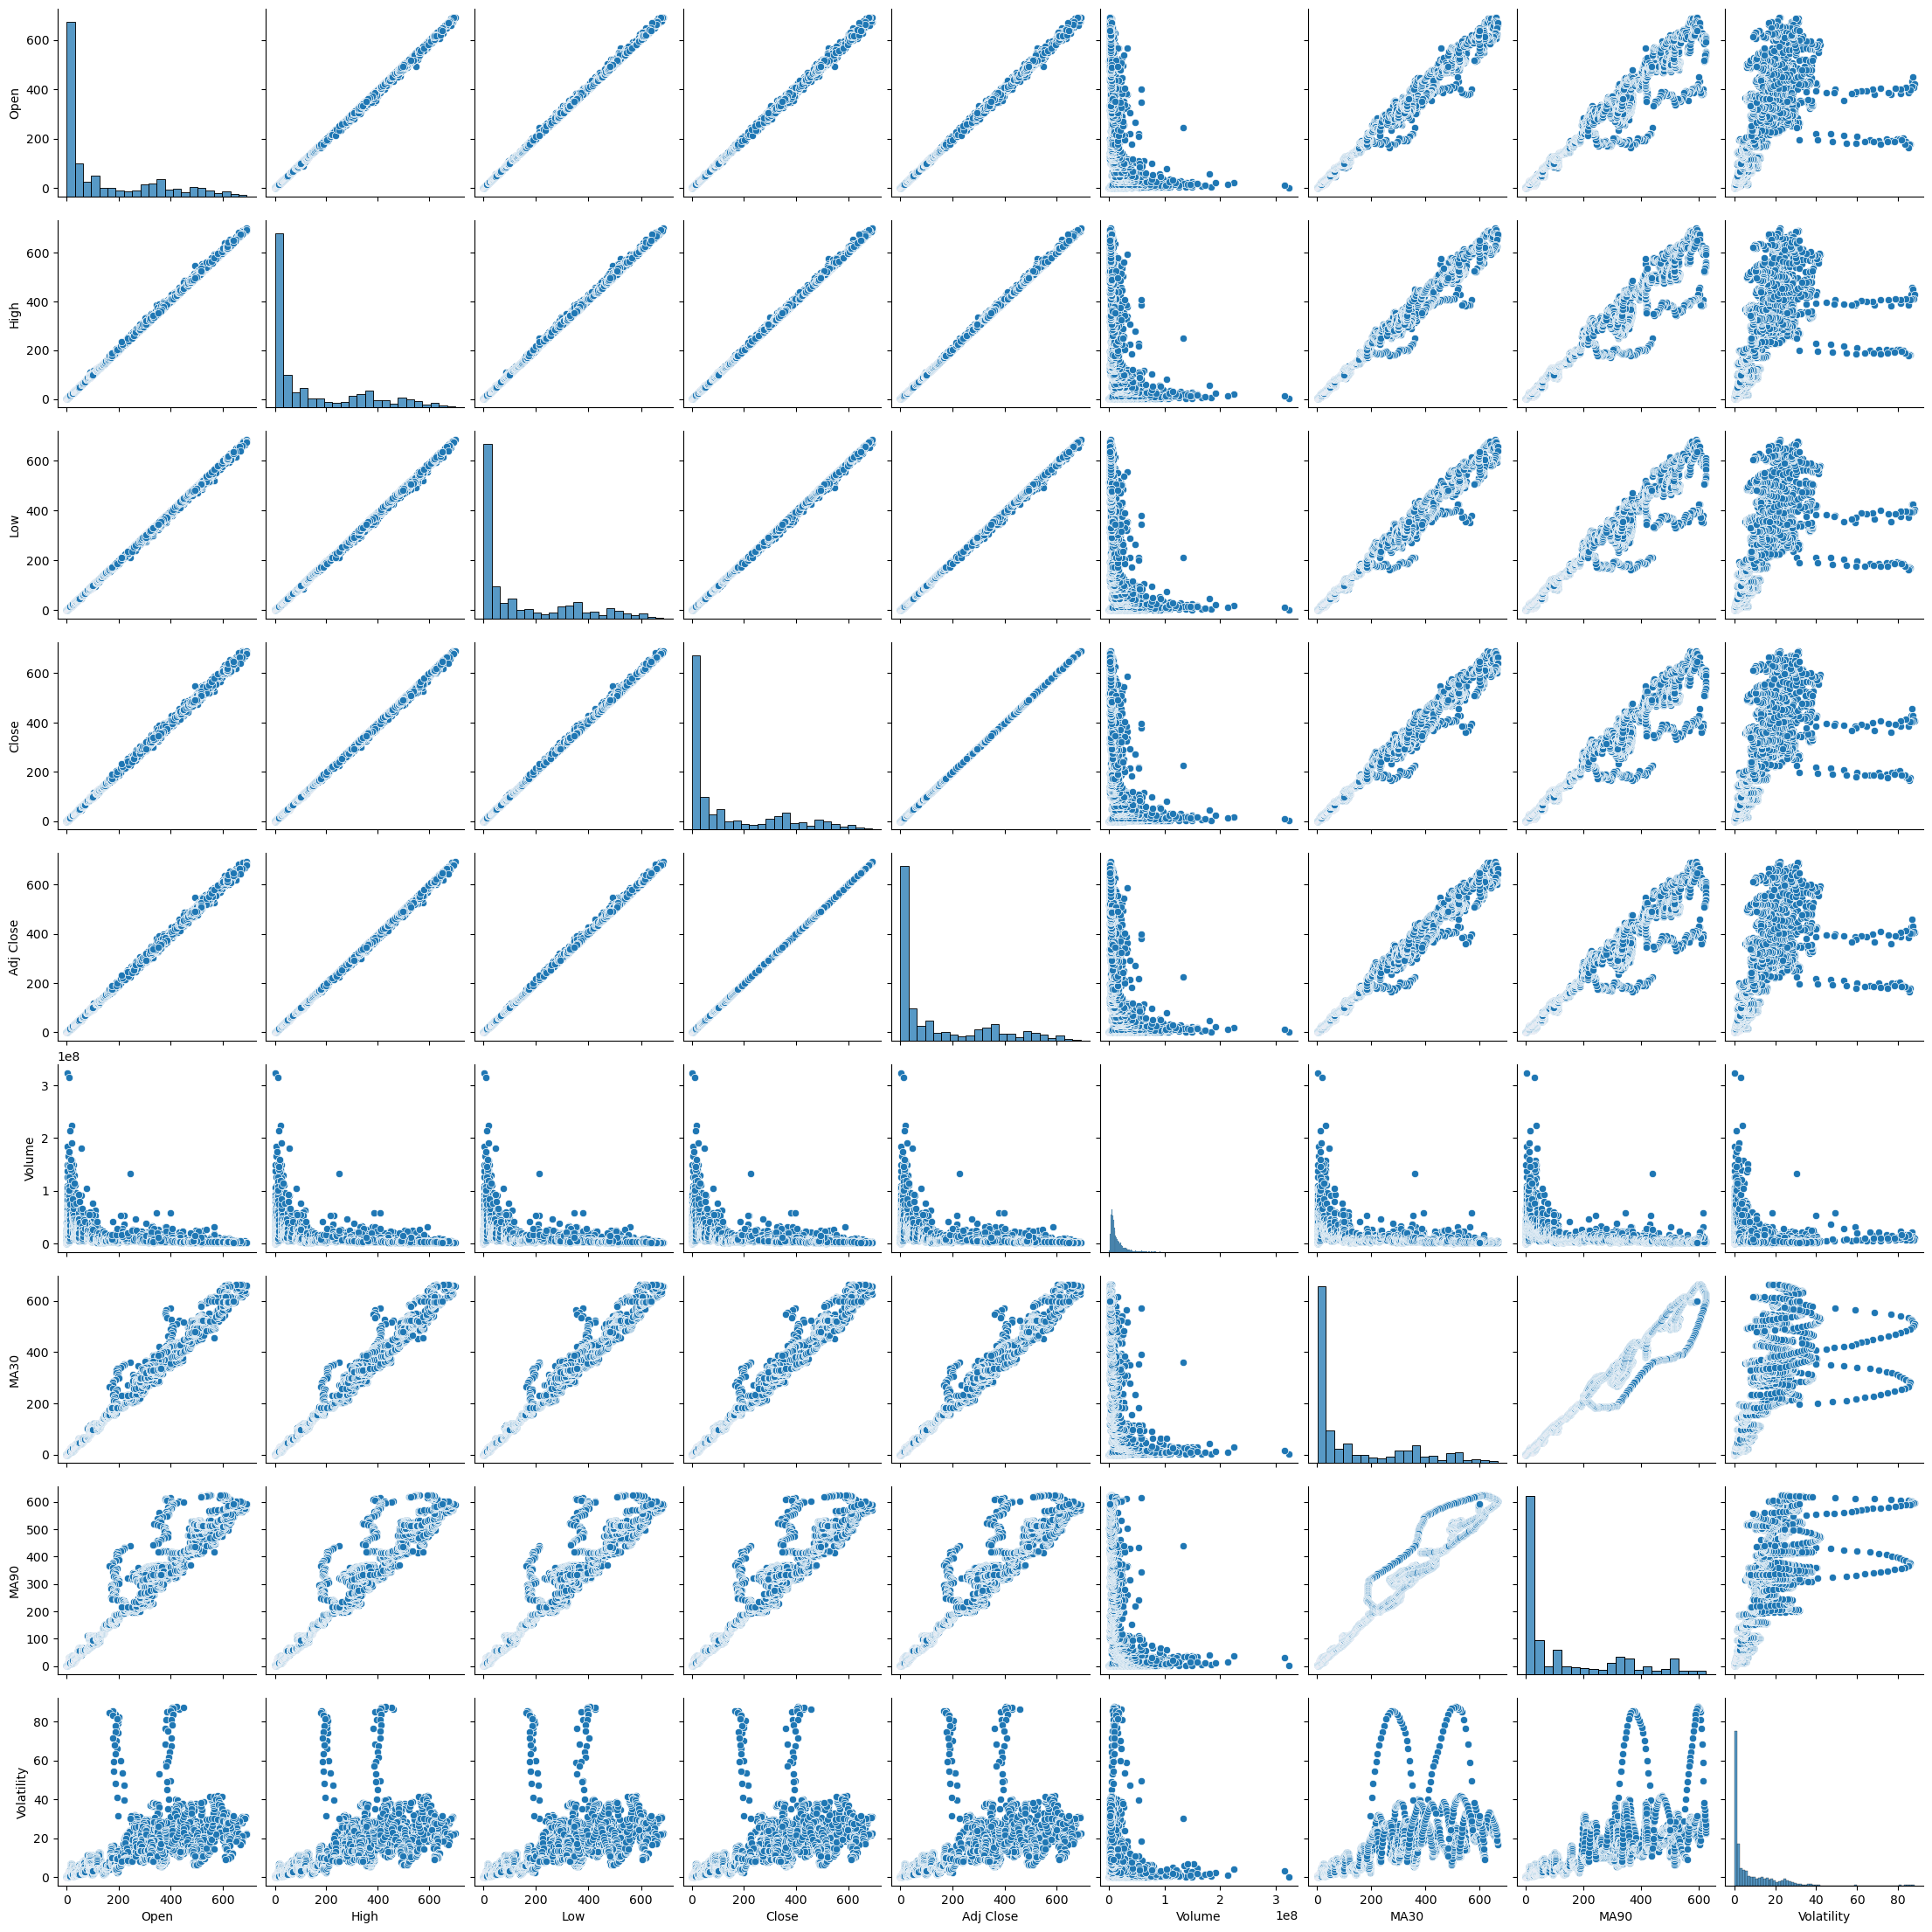

In [38]:
# Pair Plot: Relationships between all numerical columns
sns.pairplot(df.dropna())
plt.show()

In [48]:
df[df['Close'] <= 0.9 ]

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,dates,MA30,MA90,Volatility
44,2002-07-26,1.050000,1.058571,0.850000,0.871429,0.871429,7046200,2002,07,26,1.075238,NaN,0.114469
45,2002-07-29,0.896429,0.924286,0.850000,0.876429,0.876429,3260600,2002,07,29,1.071572,NaN,0.119080
48,2002-08-01,0.950000,0.960000,0.877857,0.891429,0.891429,4529000,2002,08,01,1.070738,NaN,0.120298
49,2002-08-02,0.886429,0.887857,0.706429,0.777857,0.777857,6655600,2002,08,02,1.064762,NaN,0.130183
50,2002-08-05,0.778571,0.812857,0.760714,0.775000,0.775000,3808000,2002,08,05,1.057952,NaN,0.139796
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2003-02-04,0.900000,0.910714,0.860714,0.878571,0.878571,2039800,2003,02,04,0.825238,0.722992,0.068842
177,2003-02-05,0.875714,0.885714,0.844286,0.852857,0.852857,3484600,2003,02,05,0.828190,0.723770,0.068033
178,2003-02-06,0.854286,0.857143,0.824286,0.832143,0.832143,3735200,2003,02,06,0.831524,0.725016,0.065570
179,2003-02-07,0.842857,0.875000,0.835000,0.870000,0.870000,5016200,2003,02,07,0.836952,0.726984,0.061534
